In [25]:
import pandas as pd
import networkx as nx # Para crear y manejar grafos
import matplotlib.pyplot as plt # Para dibujar los grafos estáticos
import io
import math
import os
import numpy as np # Útil para cálculos numéricos

In [5]:
#!pip install pyvis

In [26]:
try:
    df = pd.read_csv("df_final1.csv")
    print("Archivo CSV cargado correctamente.")
    # Limpieza
    df.dropna(subset=['main_class', 'Time'], inplace=True)
    df['main_class'] = df['main_class'].astype(str).str.strip()
    df = df[df['main_class'] != '']
    df['hex_color'] = df['hex_color'].astype(str).str.strip()
    # Asignar color gris por defecto si el color no es válido o falta
    df.loc[~df['hex_color'].str.startswith('#'), 'hex_color'] = '#808080'
    df['hex_color'].fillna('#808080', inplace=True) # Rellenar NaNs con gris

except FileNotFoundError:
    print("Error: El archivo 'df_final1.csv' no se encontró. Verifica la ruta.")
    df = pd.DataFrame()

Archivo CSV cargado correctamente.


/tmp/ipykernel_224368/333989851.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['hex_color'].fillna('#808080', inplace=True) # Rellenar NaNs con gris


Generando gráficos estáticos para la Imagen con Índice: 3
Para los participantes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

--- Procesando Participante 1 ---


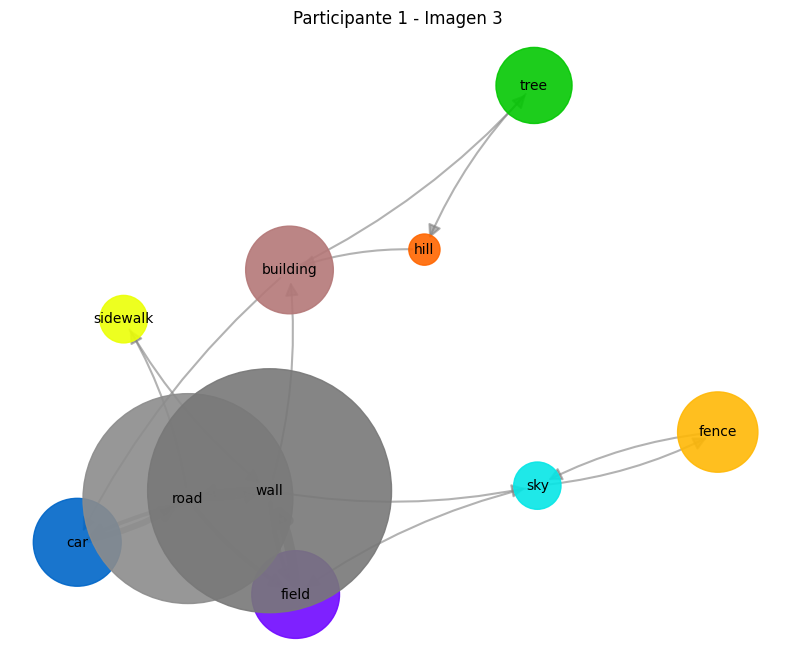


--- Procesando Participante 2 ---


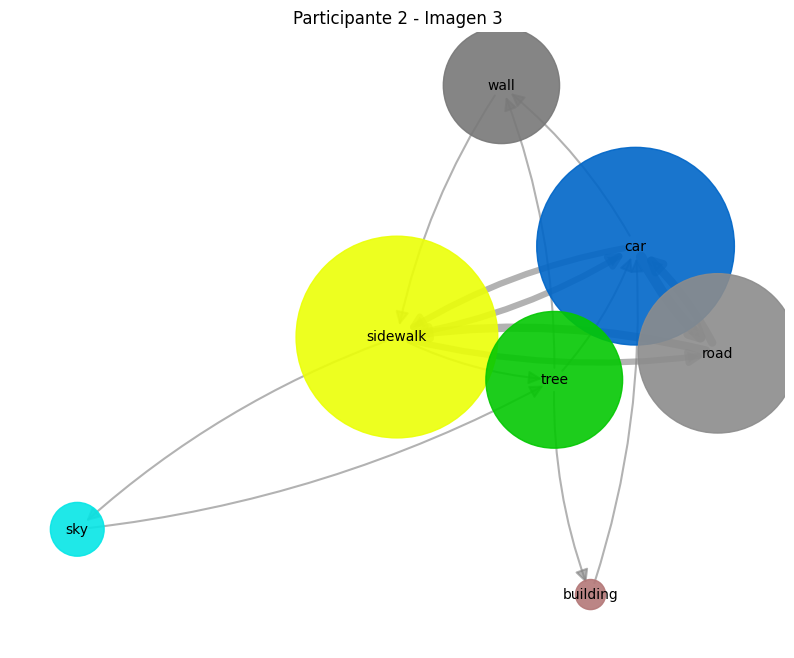


--- Procesando Participante 3 ---


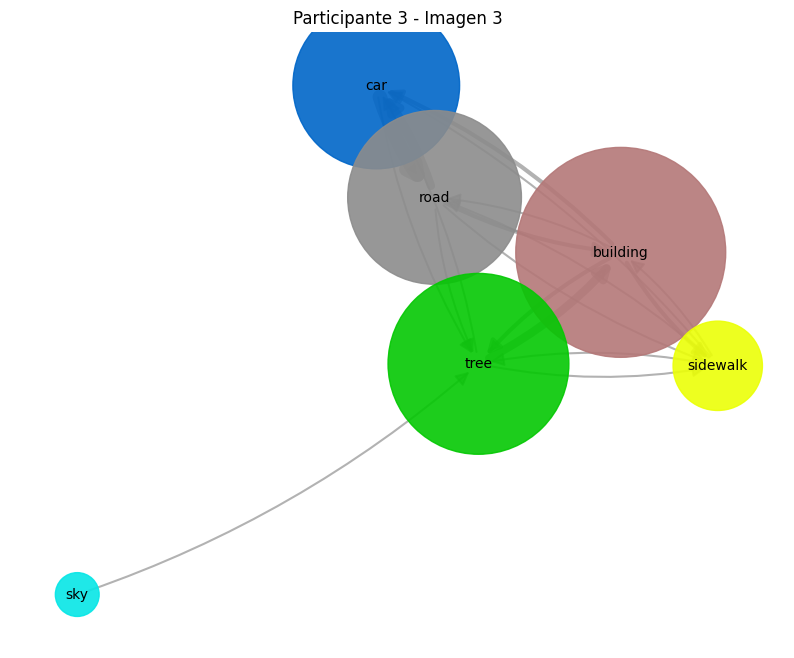


--- Procesando Participante 4 ---


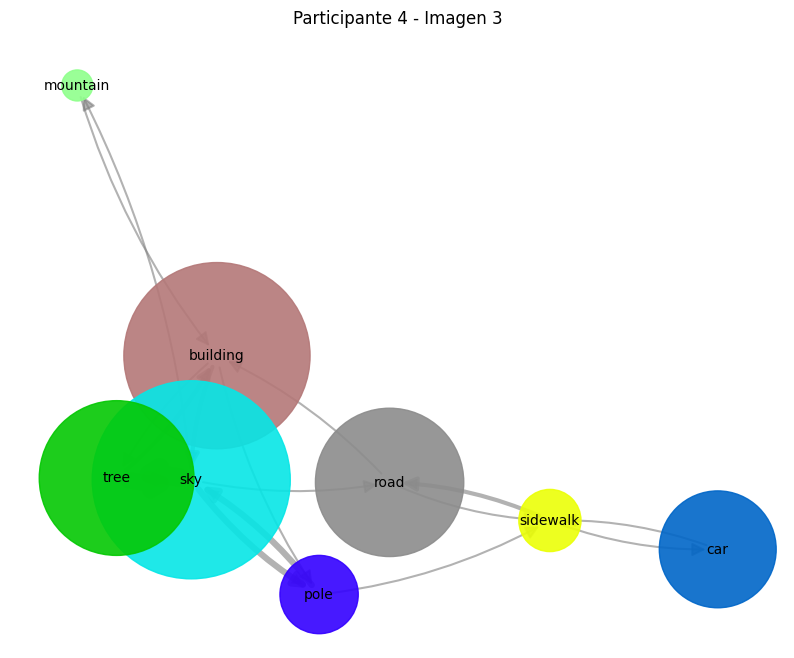


--- Procesando Participante 5 ---


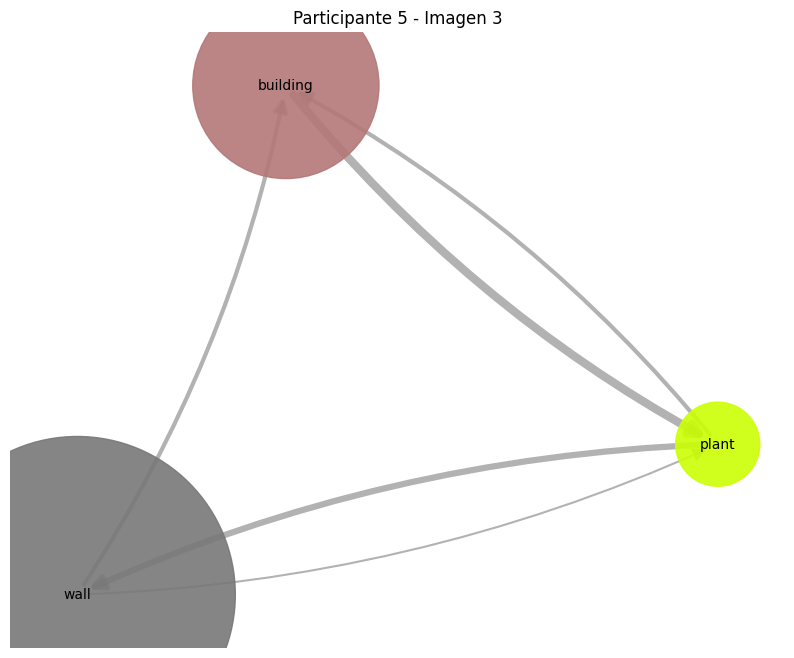


--- Procesando Participante 6 ---


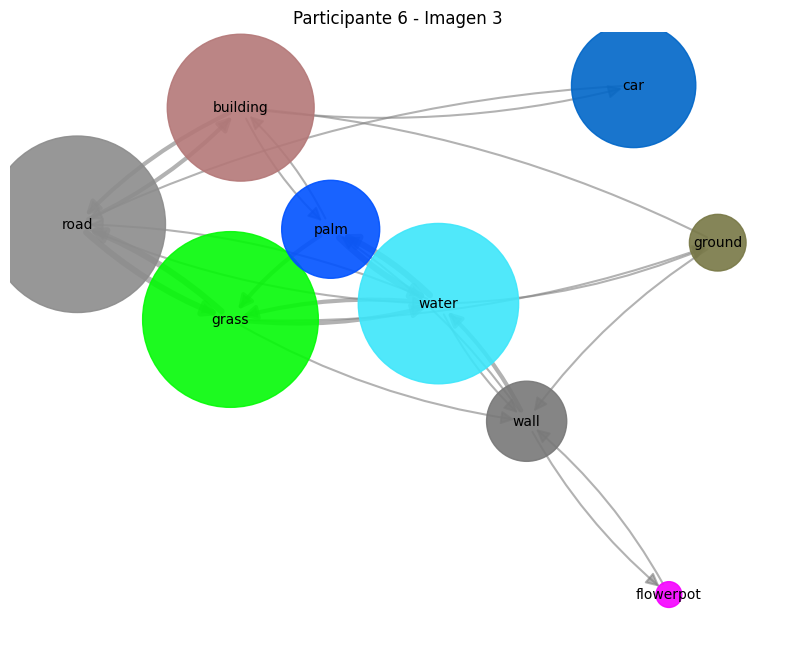


--- Procesando Participante 7 ---


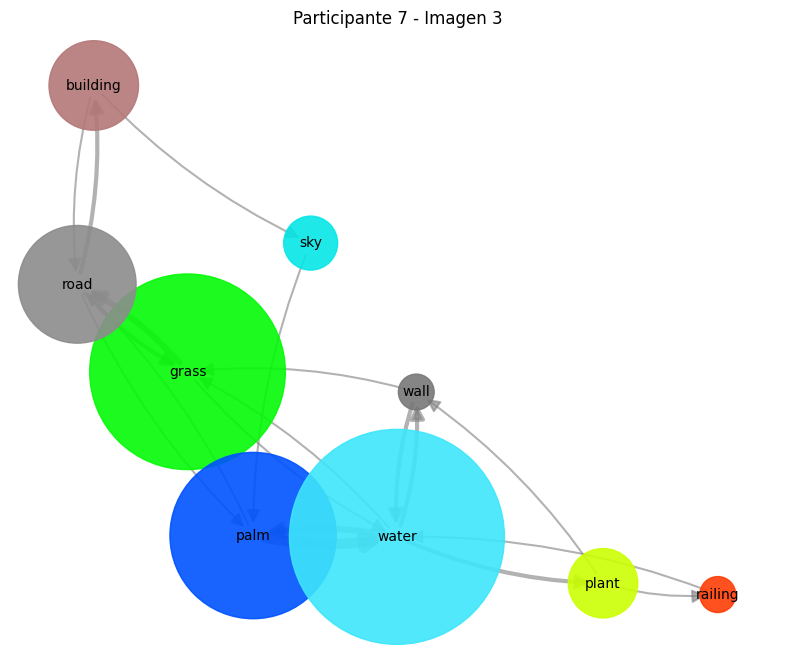


--- Procesando Participante 8 ---


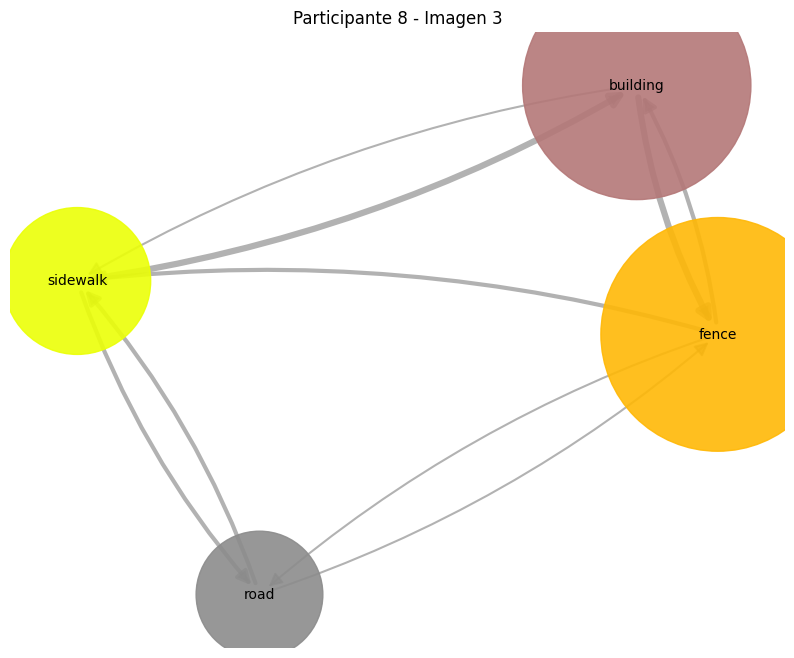


--- Procesando Participante 9 ---


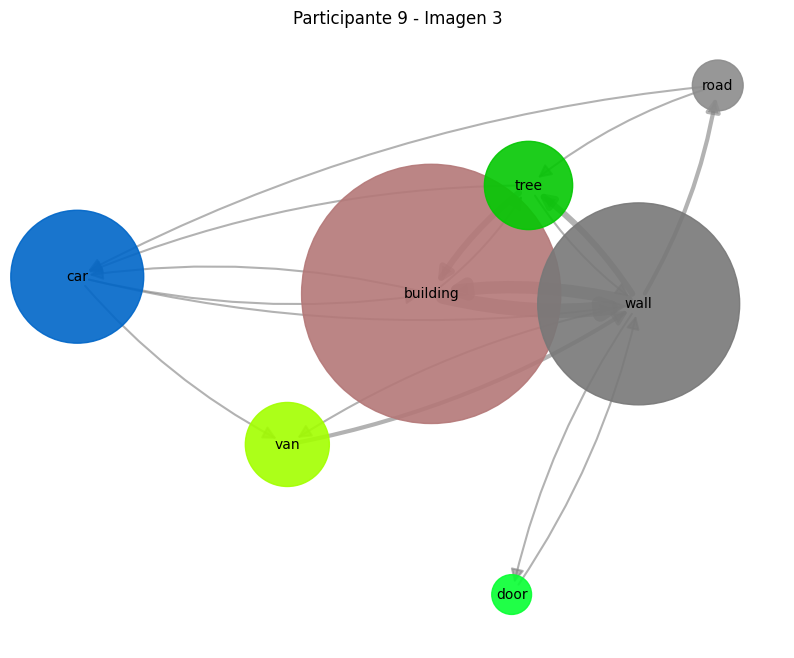


--- Procesando Participante 10 ---


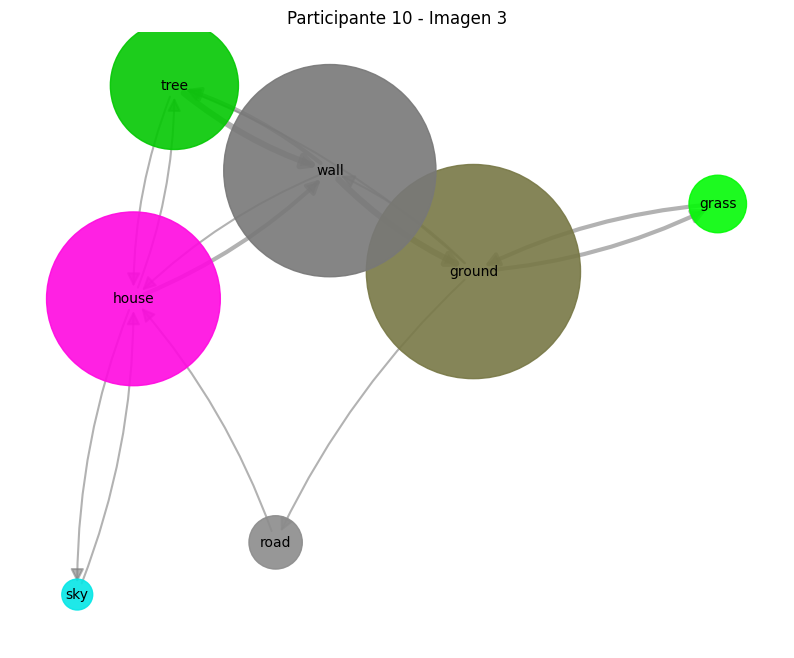

In [ ]:
# try:
#     df = pd.read_csv("df_final1.csv")
#     print("Archivo CSV cargado correctamente.")
#     # Limpieza
#     df.dropna(subset=['main_class', 'Time'], inplace=True)
#     df['main_class'] = df['main_class'].astype(str).str.strip()
#     df = df[df['main_class'] != '']
#     df['hex_color'] = df['hex_color'].astype(str).str.strip()
#     # Asignar color gris por defecto si el color no es válido o falta
#     df.loc[~df['hex_color'].str.startswith('#'), 'hex_color'] = '#808080'
#     df['hex_color'].fillna('#808080', inplace=True) # Rellenar NaNs con gris

# except FileNotFoundError:
#     print("Error: El archivo 'df_final1.csv' no se encontró. Verifica la ruta.")
#     df = pd.DataFrame()

IMAGEN_INDEX_SELECCIONADO = 3 # <--- CAMBIA ESTE VALOR
PARTICIPANTES_A_ANALIZAR = range(1, 11)

print(f"Generando gráficos estáticos para la Imagen con Índice: {IMAGEN_INDEX_SELECCIONADO}")
print(f"Para los participantes: {list(PARTICIPANTES_A_ANALIZAR)}")

# %% [code] {"id":"loop_plot_static"}
# --- 3. Bucle para Generar Gráficos Estáticos ---

if not df.empty:
    # Ajusta el tamaño general de las figuras
    plt.rcParams['figure.figsize'] = (10, 8) 

    for participante_id in PARTICIPANTES_A_ANALIZAR:
        print(f"\n--- Procesando Participante {participante_id} ---")

        df_participant = df[(df['participante'] == participante_id) & (df['ImageIndex'] == IMAGEN_INDEX_SELECCIONADO)].copy()

        if df_participant.empty:
            print(f"No hay datos para el participante {participante_id} en la imagen {IMAGEN_INDEX_SELECCIONADO}.")
            continue

        df_participant.sort_values(by='Time', inplace=True)
        df_participant['duration'] = df_participant['Time'].diff().fillna(0)

        # Cálculos (igual que antes)
        dwell_times = df_participant.groupby('main_class')['duration'].sum()
        color_map = df_participant.drop_duplicates(subset=['main_class']).set_index('main_class')['hex_color'].to_dict()

        aoi_sequence = df_participant['main_class'][df_participant['main_class'].shift() != df_participant['main_class']]
        transitions = pd.DataFrame({'source': aoi_sequence, 'target': aoi_sequence.shift(-1)}).dropna()
        transition_counts = transitions.groupby(['source', 'target']).size()

        # --- Creación del Grafo con NetworkX ---
        G = nx.DiGraph()

        # Añadir Nodos con atributos
        valid_aois = dwell_times[dwell_times > 0].index # Considerar solo AOIs con tiempo > 0
        node_sizes_list = []
        node_colors_list = []
        node_labels = {}

        NODE_AREA_SCALING = 5000 # Factor de escala para el ÁREA del nodo (ajusta según necesites)

        for aoi in valid_aois:
            if pd.notna(aoi) and aoi != '':
                G.add_node(aoi)
                # Tamaño basado en área (sqrt(duración) * factor) -> radio -> área pi*r^2
                # Para matplotlib, node_size es el área
                size = dwell_times.get(aoi, 0) * NODE_AREA_SCALING 
                node_sizes_list.append(max(size, 100)) # Tamaño mínimo para visibilidad
                
                color = color_map.get(aoi, '#808080')
                if not isinstance(color, str) or not color.startswith('#'):
                     color = '#808080' # Asegurar color válido
                node_colors_list.append(color)
                node_labels[aoi] = aoi # Etiquetas para los nodos

        # Añadir Aristas con atributos
        edge_widths_list = []
        edges_to_add = []
        EDGE_WIDTH_SCALING = 1.5 # Factor de escala para grosor (ajusta según necesites)

        for (source, target), frequency in transition_counts.items():
            # Asegurarse que ambos nodos existen en el grafo antes de añadir la arista
            if pd.notna(source) and source != '' and pd.notna(target) and target != '' and G.has_node(source) and G.has_node(target):
                 edges_to_add.append((source, target))
                 G.add_edge(source, target, weight=frequency) # Guardar frecuencia como 'weight'
                 edge_widths_list.append(frequency * EDGE_WIDTH_SCALING)

        # --- Dibujar el Grafo con Matplotlib ---
        if not G.nodes:
            print(f"No hay nodos válidos para dibujar para el participante {participante_id}.")
            continue
            
        # Elegir un layout (posiciones de los nodos)
        # spring_layout es común, pero puedes probar otros: circular_layout, kamada_kawai_layout, etc.
        pos = nx.spring_layout(G, k=0.5, iterations=50) # Ajusta 'k' e 'iterations' para cambiar la disposición

        plt.figure() # Crear una nueva figura para cada gráfico

        # Dibujar nodos
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes_list, node_color=node_colors_list, alpha=0.9)

        # Dibujar aristas (flechas)
        nx.draw_networkx_edges(G, pos, edgelist=edges_to_add, width=edge_widths_list, 
                               arrowstyle='-|>', arrowsize=20, edge_color='grey', alpha=0.6,
                               connectionstyle='arc3,rad=0.1') # Curvar un poco las flechas

        # Dibujar etiquetas
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

        plt.title(f'Participante {participante_id} - Imagen {IMAGEN_INDEX_SELECCIONADO}')
        plt.axis('off') # Ocultar ejes
        plt.show() # Mostrar el gráfico estático

else:
    print("El DataFrame está vacío. No se pueden generar gráficos.")

In [22]:
df_filtered['duration']

0      0.000
1      0.033
2      0.035
3      0.032
4      0.033
       ...  
409    0.033
410    0.036
411    0.031
412    0.033
413    0.036
Name: duration, Length: 402, dtype: float64

In [24]:
from IPython.display import IFrame 

if not df.empty: # Solo proceder si el DataFrame se cargó
    for participante_id in PARTICIPANTES_A_ANALIZAR:
        print(f"\n--- Procesando Participante {participante_id} ---")
        
        df_participant = df[(df['participante'] == participante_id) & (df['ImageIndex'] == IMAGEN_INDEX_SELECCIONADO)].copy()
        
        if df_participant.empty:
            print(f"No se encontraron datos para el participante {participante_id} en la imagen {IMAGEN_INDEX_SELECCIONADO}.")
            continue 
            
        df_participant.sort_values(by='Time', inplace=True) 
        df_participant['duration'] = df_participant['Time'].diff().fillna(0)
        
        dwell_times = df_participant.groupby('main_class')['duration'].sum()
        color_map = df_participant.drop_duplicates(subset=['main_class']).set_index('main_class')['hex_color'].to_dict()
        
        aoi_sequence = df_participant['main_class'][df_participant['main_class'].shift() != df_participant['main_class']]
        transitions = pd.DataFrame({'source': aoi_sequence, 'target': aoi_sequence.shift(-1)}).dropna() 
        transition_counts = transitions.groupby(['source', 'target']).size()
        
        # CAMBIO 1: Usar cdn_resources='remote'
        net = Network(height='500px', 
                      width='95%', 
                      directed=True, 
                      heading=f'Participante {participante_id} - Imagen {IMAGEN_INDEX_SELECCIONADO}',
                      cdn_resources='remote') # <--- CAMBIO AQUÍ

        NODE_SCALING_FACTOR = 30 
        for aoi, total_time in dwell_times.items():
            if pd.notna(aoi) and aoi != '':
                node_size = math.sqrt(total_time) * NODE_SCALING_FACTOR if total_time > 0 else 10
                node_color = color_map.get(aoi, '#808080') 
                if not isinstance(node_color, str) or not node_color.startswith('#'):
                     node_color = '#808080' 

                net.add_node(str(aoi), label=str(aoi), value=node_size, 
                             title=f'Duración: {total_time:.2f}s', color=node_color)

        EDGE_SCALING_FACTOR = 2 
        for (source, target), frequency in transition_counts.items():
            if pd.notna(source) and source != '' and pd.notna(target) and target != '' and str(source) in net.node_ids and str(target) in net.node_ids:
                 net.add_edge(str(source), str(target), value=frequency * EDGE_SCALING_FACTOR, 
                              title=f'Transiciones: {frequency}')

        net.set_options("""
        var options = {
          "physics": {
            "forceAtlas2Based": {
              "gravitationalConstant": -50,
              "centralGravity": 0.015,
              "springLength": 100,
              "springConstant": 0.08,
              "avoidOverlap": 0.5 
            },
            "minVelocity": 0.75,
            "solver": "forceAtlas2Based"
          },
          "edges": { "smooth": { "type": "cubicBezier", "forceDirection": "horizontal", "roundness": 0.7 } }
        }
        """)

        file_name = os.path.join(output_dir, f'grafo_p{participante_id}_img{IMAGEN_INDEX_SELECCIONADO}.html')
        try:
            net.save_graph(file_name) # Guardamos el gráfico en HTML
            print(f"Gráfico guardado en: {file_name}")
            
            # CAMBIO 2: Usar IFrame para mostrar el archivo guardado
            display(IFrame(src=file_name, width="100%", height="525px")) # <-- CAMBIO AQUÍ (Ajusta height si es necesario)
            
        except Exception as e:
            print(f"Error al guardar o mostrar el gráfico para el participante {participante_id}: {e}")

else:
    print("El DataFrame está vacío. No se pueden generar gráficos.")

# %% [markdown] {"id":"seaborn_note"}
# **Nota sobre Seaborn:** Como se mencionó, Seaborn no es la herramienta adecuada para este tipo de gráfico de red. `pyvis` genera los gráficos interactivos de nodos y flechas que necesitas, similares a D3.js. Podríamos usar Seaborn para visualizar *otros aspectos* de los datos, como un mapa de calor de las transiciones entre AOIs o un gráfico de barras del tiempo total en cada AOI para comparar participantes, si te interesa.

# %% [code] {"id":"a9ed70b4"}
# Celda vacía al final para futuras adiciones


--- Procesando Participante 1 ---
Gráfico guardado en: grafos_html/grafo_p1_img3.html



--- Procesando Participante 2 ---
Gráfico guardado en: grafos_html/grafo_p2_img3.html



--- Procesando Participante 3 ---
Gráfico guardado en: grafos_html/grafo_p3_img3.html



--- Procesando Participante 4 ---
Gráfico guardado en: grafos_html/grafo_p4_img3.html



--- Procesando Participante 5 ---
Gráfico guardado en: grafos_html/grafo_p5_img3.html



--- Procesando Participante 6 ---
Gráfico guardado en: grafos_html/grafo_p6_img3.html



--- Procesando Participante 7 ---
Gráfico guardado en: grafos_html/grafo_p7_img3.html



--- Procesando Participante 8 ---
Gráfico guardado en: grafos_html/grafo_p8_img3.html



--- Procesando Participante 9 ---
Gráfico guardado en: grafos_html/grafo_p9_img3.html



--- Procesando Participante 10 ---
Gráfico guardado en: grafos_html/grafo_p10_img3.html


In [16]:
# --- 4. Crear el Gráfico de Red con Pyvis ---

# Inicializar el objeto de red
# 'notebook=True' es para que se muestre en el Jupyter Notebook
net = Network(height='750px', width='100%', notebook=True, directed=True)

# Añadir nodos (las AOIs)
for aoi, total_time in dwell_times.items():
    # El tamaño del nodo será proporcional al tiempo de permanencia.
    # Usamos la raíz cuadrada para que las diferencias no sean tan extremas.
    # El '20' es un factor de escala que puedes ajustar.
    node_size = math.sqrt(total_time) * 20
    
    net.add_node(
        aoi, 
        label=aoi, 
        value=node_size, # pyvis usa 'value' para el tamaño
        title=f'Dwell Time: {total_time:.2f}s', # Texto que aparece al pasar el ratón
        color=color_map.get(aoi, '#808080') # Usar el color del CSV o gris si no se encuentra
    )

# Añadir arcos (las transiciones)
for (source, target), frequency in transition_counts.items():
    if pd.notna(source) and pd.notna(target):
        net.add_edge(
            source, 
            target, 
            value=frequency, # pyvis usa 'value' para el grosor
            title=f'Transitions: {frequency}'
        )



In [17]:
# Configurar la física del gráfico para una mejor visualización
net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -2000,
      "centralGravity": 0.3,
      "springLength": 95,
      "springConstant": 0.04
    },
    "maxVelocity": 50,
    "minVelocity": 0.1,
    "solver": "barnesHut",
    "stabilization": {
      "enabled": true,
      "iterations": 1000,
      "updateInterval": 50,
      "onlyDynamicEdges": false,
      "fit": true
    },
    "timestep": 0.5,
    "adaptiveTimestep": true
  },
  "interaction": {
      "navigationButtons": true,
      "keyboard": true
  }
}
""")


# --- 5. Generar y Mostrar el Gráfico ---

# Generar un archivo HTML con el gráfico
file_name = f'scanpath_graph_participante_{PARTICIPANTE_ID}_imagen_{IMAGEN_ID}.html'
net.show(file_name)

print(f"¡Gráfico generado! Abre el archivo '{file_name}' en tu navegador.")

# Si quieres mostrarlo directamente en el notebook (puede no funcionar en todos los entornos)
# display(HTML(net.html))

scanpath_graph_participante_1_imagen_0.html
¡Gráfico generado! Abre el archivo 'scanpath_graph_participante_1_imagen_0.html' en tu navegador.
